<a href="https://colab.research.google.com/github/rahulpatwal07/tensorflow-course/blob/main/05_transer_learning_with_tensorflow_part_2_fine_tuning_ipnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow : Part-2 Fine tuning

In [ ]:
# Check if we're using a GPU
!nvidia-smi

Mon Jun  3 12:52:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating a helper functions





In [ ]:
# Importing helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-03 12:52:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-03 12:52:31 (78.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Importing functions from helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

 ## Let's get the data

 This time we're going to see how we use the pretrained models within tf.keras.applications and apply then to our model

In [ ]:
# Get 10% of training data of 10 classes of Food101

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-06-03 12:52:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.207, 74.125.26.207, 172.217.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  69.4MB/s    in 2.3s    

2024-06-03 12:52:41 (69.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directory path
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    image_size=IMG_SIZE,
                                                                    label_mode='categorical',
                                                                    batch_size=32,
                                                                    )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out class name
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 36.07143     35.07143     51.07143   ]
   [ 32.59694     31.59694     49.59694   ]
   [ 35.438774    32.438774    53.438774  ]
   ...
   [145.01532    113.87238    115.0051    ]
   [150.14804    114.387825   119.45925   ]
   [154.33145    114.97431    121.04574   ]]

  [[ 32.55102     31.55102     47.55102   ]
   [ 34.785713    33.785713    51.785713  ]
   [ 35.285713    32.285713    53.285713  ]
   ...
   [139.04083    108.48467    105.341835  ]
   [139.28572    105.28573    103.500015  ]
   [147.65833    111.658325   111.801186  ]]

  [[ 28.948978    27.948978    43.94898   ]
   [ 27.80102     26.80102     42.801018  ]
   [ 25.95408     22.95408     41.52551   ]
   ...
   [137.71428    107.974464    99.49998   ]
   [145.14275    112.78561    105.015175  ]
   [132.09183     99.73469     91.45402   ]]

  ...

  [[  2.6429005    9.071428     0.28061998]
   [  8.913334    17.000046     0.        ]
   [ 38.64763     49.6731      11.673163  ]
   ...
   [ 31.857056    13.979

## Model 0: Building a transfer learning using keras functinal api

The Sequential API is straight forward, it runs our layers in sequential order.
But the functional API fives us more flexibility with out models.

In [ ]:
# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre_trained patterns aren't update here)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/225.)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through the base model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_laye')(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,epochs=5,
                steps_per_epoch = len(train_data_10_percent),
                validation_data=test_data,
                validation_steps=0.25*len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through the base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240603-125252
Epoch 1/5
24/24 [==============================] - 20s 391ms/step - loss: 1.8797 - accuracy: 0.4253 - val_loss: 1.3127 - val_accuracy: 0.7281
Epoch 2/5
24/24 [==============================] - 4s 139ms/step - loss: 1.0852 - accuracy: 0.7667 - val_loss: 0.8803 - val_accuracy: 0.8219
Epoch 3/5
24/24 [==============================] - 6s 208ms/step - loss: 0.7861 - accuracy: 0.8173 - val_loss: 0.7294 - val_accuracy: 0.8266
Epoch 4/5
24/24 [==============================] - 4s 144ms/step - loss: 0.6414 - accuracy: 0.8453 - val_loss: 0.6160 - val_accuracy: 0.8562
Epoch 5/5
24/24 [==============================] - 4s 132ms/step - loss: 0.5460 - accuracy: 0.8827 - val_loss: 0.5808 - val_accuracy: 0.8531


In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.5619 - accuracy: 0.8616


[0.5619383454322815, 0.8615999817848206]

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 e (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


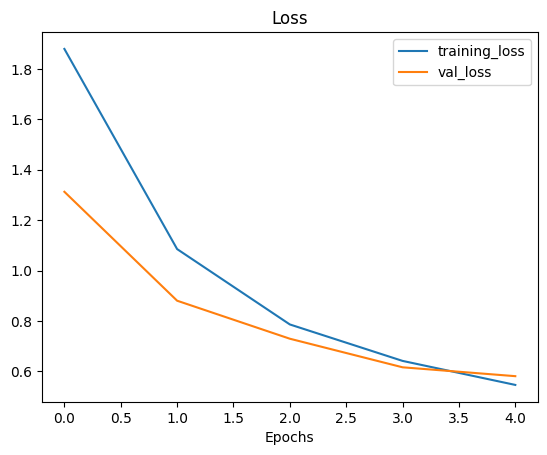

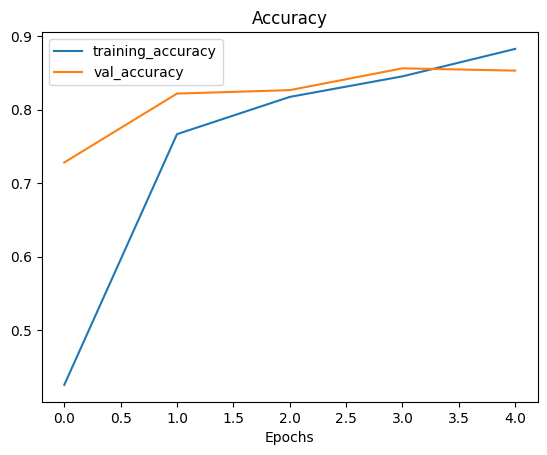

In [ ]:
plot_loss_curves(history_0)

## Getting a feature vector from a trained mdoel

Let's demostrate the Global Average Pooling 2D layer...
 We have a tensor after our model through 'base_model' of shape (None, 7, 7, 1280).

 But when it passes through GlobalAveragePooling2D, it turn into (None, 1280).

 Let's use a similar shaped tensor of (1, 4, 4, 3) and passes it to GlobalAveragePooling2D.

In [ ]:
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_layer = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_layer}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [ ]:
print(f"The shape of input tensor: {input_tensor.shape}")
print(f"The shape of global average pooled tensor: {global_average_pooled_layer.shape}")

The shape of input tensor: (1, 4, 4, 3)
The shape of global average pooled tensor: (1, 3)


In [ ]:
# Let's replicate the GlovalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Try same with GlobalMaxPool2d

In [ ]:
global_max_pooled_layer = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_layer}\n")

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]



In [ ]:
reduced_max = tf.reduce_max(input_tensor, axis=[1, 2])
reduced_max

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

In [ ]:
global_max_pooled_layer == reduced_max

<tf.Tensor: shape=(1, 3), dtype=bool, numpy=array([[ True,  True,  True]])>

## Running a series of transfer learning experiments

Let's see how does it go with 1% of training data...

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2.`model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

## Model_1

In [ ]:
# Download and unzip data
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2024-06-03 12:53:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.207, 108.177.11.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   102MB/s    in 1.2s    

2024-06-03 12:53:43 (102 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# create training and test dir
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There a

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                    image_size=IMG_SIZE,
                                                                    label_mode='categorical',
                                                                    batch_size=32,
                                                                    )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation

To add data augmentation right into our model, we can use the layers inside:
tf.keras.layers.experimental


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name = "data_augmentation")

### Visualize our data augmentation layer

(-0.5, 404.5, 414.5, -0.5)

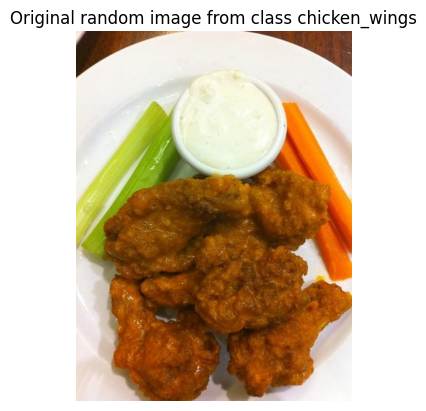

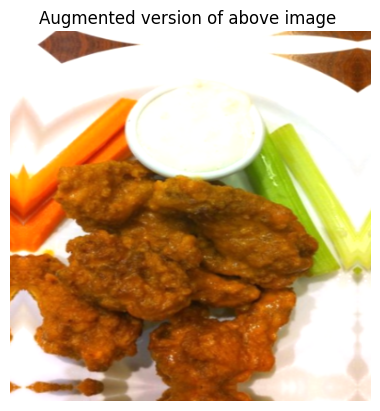

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Let's now plot augmented image
augmented_image = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/225.)
plt.title(f"Augmented version of above image ")
plt.axis(False)

### Let's create our model_1 : Feature extraction transfer learning with 1% data and data augmentation



In [ ]:
# Setup input shape and base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = input_shape, name='input_layer')

# Add data augmentation Sequential model as a layer
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
history_1 = model_1.fit(train_data_1_percent,
            epochs=5,
            steps_per_epoch=len(train_data_1_percent),
            validation_data=test_data,
            validation_steps=int(0.25*len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                   experiment_name='1_percent_data_aug')])

24274472/24274472 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240603-125351
Epoch 1/5
3/3 [==============================] - 18s 5s/step - loss: 2.3338 - accuracy: 0.0857 - val_loss: 2.1480 - val_accuracy: 0.2385
Epoch 2/5
3/3 [==============================] - 6s 2s/step - loss: 2.0957 - accuracy: 0.2286 - val_loss: 2.0306 - val_accuracy: 0.3092
Epoch 3/5
3/3 [==============================] - 9s 4s/step - loss: 1.9369 - accuracy: 0.3143 - val_loss: 1.9276 - val_accuracy: 0.3750
Epoch 4/5
3/3 [==============================] - 7s 2s/step - loss: 1.7868 - accuracy: 0.4857 - val_loss: 1.8556 - val_accuracy: 0.4243
Epoch 5/5
3/3 [==============================] - 7s 2s/step - loss: 1.6960 - accuracy: 0.5571 - val_loss: 1.7748 - val_accuracy: 0.4901


In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 9s 109ms/step - loss: 1.7870 - accuracy: 0.4636


[1.7869503498077393, 0.4636000096797943]

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

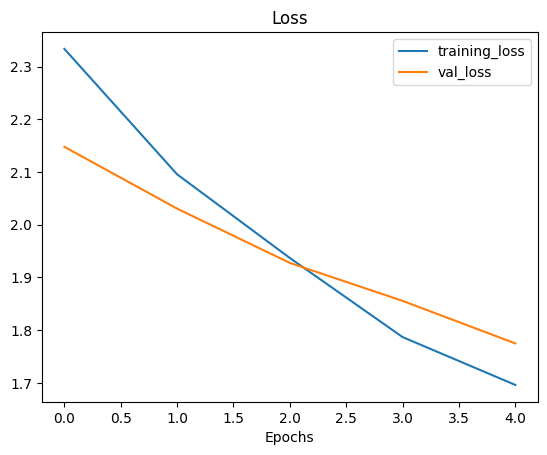

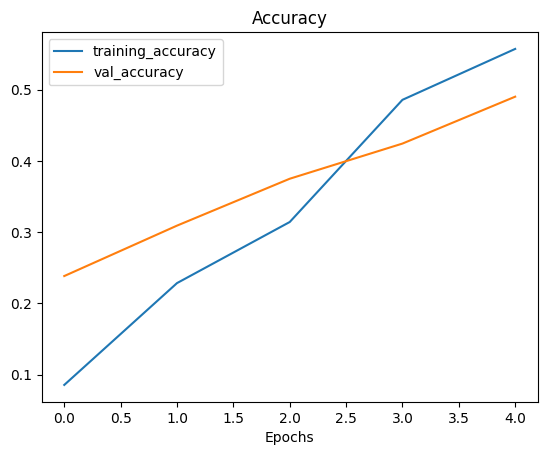

In [ ]:
plot_loss_curves(history_1)

## Model_2 - 10% training data with data augmentation

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                    image_size=IMG_SIZE,
                                                                    label_mode='categorical',
                                                                    batch_size=32,
                                                                    )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = input_shape, name='input_layer')

# Add data augmentation Sequential model as a layer
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
history_2 = model_2.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.25*len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                   experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240603-125504
Epoch 1/5
3/3 [==============================] - 14s 3s/step - loss: 2.4394 - accuracy: 0.1143 - val_loss: 2.2775 - val_accuracy: 0.1151
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1413 - accuracy: 0.2143 - val_loss: 2.1642 - val_accuracy: 0.1595
Epoch 3/5
3/3 [==============================] - 8s 3s/step - loss: 2.0454 - accuracy: 0.2143 - val_loss: 2.0653 - val_accuracy: 0.2336
Epoch 4/5
3/3 [==============================] - 8s 3s/step - loss: 1.8460 - accuracy: 0.3857 - val_loss: 1.9843 - val_accuracy: 0.2714
Epoch 5/5
3/3 [==============================] - 9s 4s/step - loss: 1.7926 - accuracy: 0.3857 - val_loss: 1.9096 - val_accuracy: 0.3339


In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 62ms/step - loss: 1.8884 - accuracy: 0.3488


[1.888383388519287, 0.34880000352859497]

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

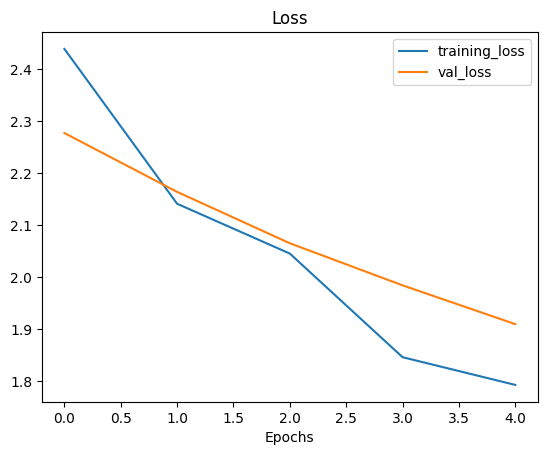

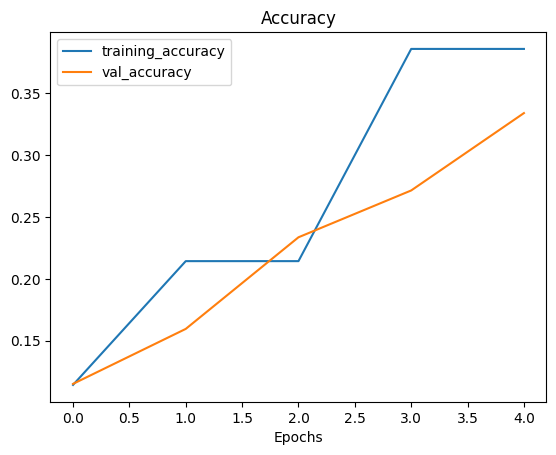

In [ ]:
plot_loss_curves(history_2)

### Creating a ModelCheckpoint callback

In [ ]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq="epoch",
                                                        verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epoch = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                         epochs=initial_epoch,
                                         validation_data=test_data,
                                         validation_steps=(0.25 * len(test_data)),
                                         callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                experiment_name="10_percent_data_aug"),
                                                    checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240603-125555
Epoch 1/5
3/3 [==============================] - ETA: 0s - loss: 1.6212 - accuracy: 0.5429
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
3/3 [==============================] - 7s 3s/step - loss: 1.6212 - accuracy: 0.5429 - val_loss: 1.8245 - val_accuracy: 0.3938
Epoch 2/5
3/3 [==============================] - ETA: 0s - loss: 1.4985 - accuracy: 0.6286
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
3/3 [==============================] - 4s 2s/step - loss: 1.4985 - accuracy: 0.6286 - val_loss: 1.7306 - val_accuracy: 0.4688
Epoch 3/5
3/3 [==============================] - ETA: 0s - loss: 1.4202 - accuracy: 0.7000
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
3/3 [==============================] - 5s 2s/step - loss: 1.4202 - accuracy: 0.7000 - val_loss: 1.6665 - val_accuracy: 0.5094
Epoch 4/5
3/3 [==========

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 5s 61ms/step - loss: 1.5308 - accuracy: 0.5772


[1.5307523012161255, 0.5771999955177307]

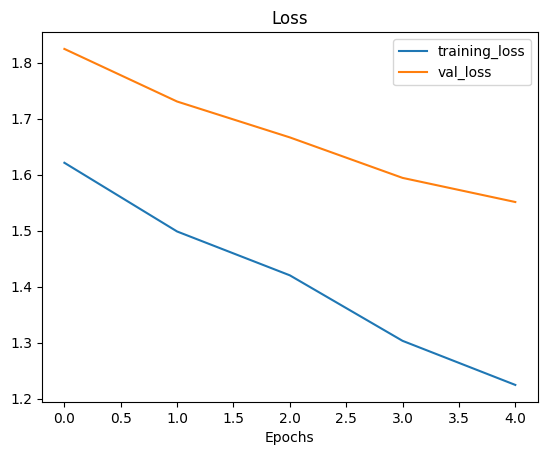

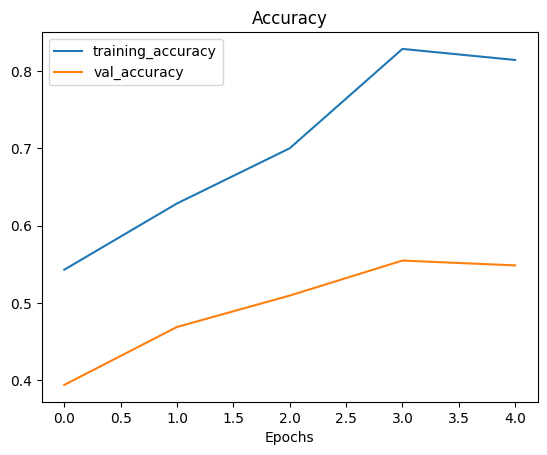

In [ ]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model with a specific checkpoint

In [ ]:
# Load in saved model weights
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 67ms/step - loss: 1.5308 - accuracy: 0.5772


In [ ]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked
results_10_percent_data_aug == loaded_weights_model_results

True

In [ ]:
results_10_percent_data_aug

[1.5307523012161255, 0.5771999955177307]

In [ ]:
loaded_weights_model_results

[1.5307523012161255, 0.5771999955177307]

In [ ]:
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# check the difference between two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


## Model 3 - Fine-turning on existing model on 10% of the data

**Note** - Fine-tuning usually works best after training a feature extraction model for a few epochs with with large amounts of custom data.

In [ ]:
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7f6bbce5a3b0> True
<keras.src.engine.sequential.Sequential object at 0x7f6bbee99030> True
<keras.src.engine.functional.Functional object at 0x7f6bbcca81f0> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f6bbcb829b0> True
<keras.src.layers.core.dense.Dense object at 0x7f6bbcb835e0> True


In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have recompile our models every time we make a change)
model_2.compile(loss = 'categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # when fine-tuning, you typically want to lower you lr by 10x
                metrics=['accuracy'])

**Note** - When using fine tuning, it's best practice to lower your leaning rate by some percentage(usually 10x).

In [ ]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
model_2.trainable_variables

[<tf.Variable 'block6h_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.00207604,  0.01300672,  0.02047416, ..., -0.02240255,
           -0.07708141, -0.00094655],
          [-0.06357138,  0.0959678 , -0.05430871, ..., -0.01352078,
           -0.05987524, -0.11093444],
          [ 0.0068749 , -0.04681807, -0.01513974, ...,  0.03073284,
           -0.01280731,  0.03616464],
          ...,
          [ 0.11381665,  0.00804447, -0.05432149, ...,  0.08015257,
           -0.06561387, -0.05522665],
          [-0.12468243,  0.06938899, -0.07634895, ...,  0.01121222,
           -0.0128268 ,  0.10406019],
          [-0.04722364,  0.10557885,  0.16247186, ...,  0.04582691,
            0.01228108, -0.04941604]]]], dtype=float32)>,
 <tf.Variable 'block6h_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([ 0.04594925,  2.5461788 , -1.426646  , -0.7885664 , -0.24730209,
        -0.5630991 , -0.6161863 , -0.4029834 , -1.4444699 , -1.0481553 ,
        -0.21704195,

In [ ]:
print(len(model_2.trainable_variables))

12


In [ ]:
fine_tune_epoch = initial_epoch + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epoch,
                                               validation_data=test_data,
                                               validation_steps = (0.25*(len(test_data))),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],# start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                      experiment_name='10_percent_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240603-125650
Epoch 5/10
3/3 [==============================] - 18s 3s/step - loss: 1.1162 - accuracy: 0.7571 - val_loss: 1.1208 - val_accuracy: 0.6484
Epoch 6/10
3/3 [==============================] - 5s 2s/step - loss: 0.5136 - accuracy: 0.9000 - val_loss: 1.1053 - val_accuracy: 0.6172
Epoch 7/10
3/3 [==============================] - 6s 2s/step - loss: 0.3588 - accuracy: 0.9143 - val_loss: 1.0564 - val_accuracy: 0.6500
Epoch 8/10
3/3 [==============================] - 7s 3s/step - loss: 0.2137 - accuracy: 0.9429 - val_loss: 1.3868 - val_accuracy: 0.6281
Epoch 9/10
3/3 [==============================] - 7s 2s/step - loss: 0.1326 - accuracy: 0.9857 - val_loss: 1.3153 - val_accuracy: 0.6422
Epoch 10/10
3/3 [==============================] - 7s 2s/step - loss: 0.0980 - accuracy: 0.9857 - val_loss: 1.1314 - val_accuracy: 0.6969


In [ ]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 11s 123ms/step - loss: 1.1578 - accuracy: 0.6916


In [ ]:
results_10_percent_data_aug

[1.5307523012161255, 0.5771999955177307]

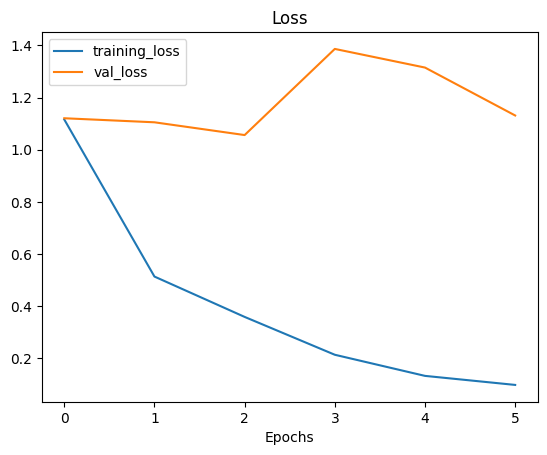

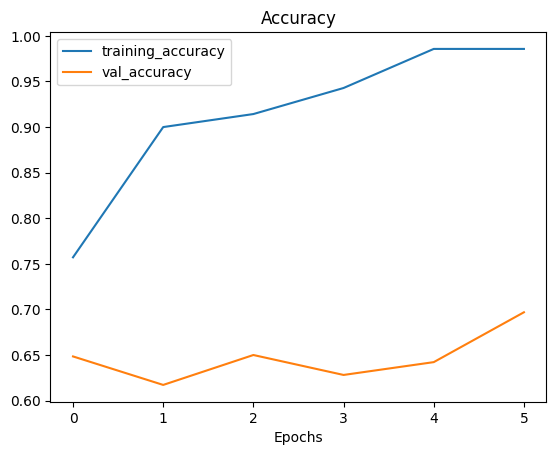

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug)

The plot_loss_curves function works great with models which have only been fit once, however we want something to compare one series of running `fit()` with another(eg - before and after fine-tunnig)

In [ ]:

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.5428571701049805, 0.6285714507102966, 0.699999988079071, 0.8285714387893677, 0.8142856955528259, 0.7571428418159485, 0.8999999761581421, 0.9142857193946838, 0.9428571462631226, 0.9857142567634583, 0.9857142567634583]


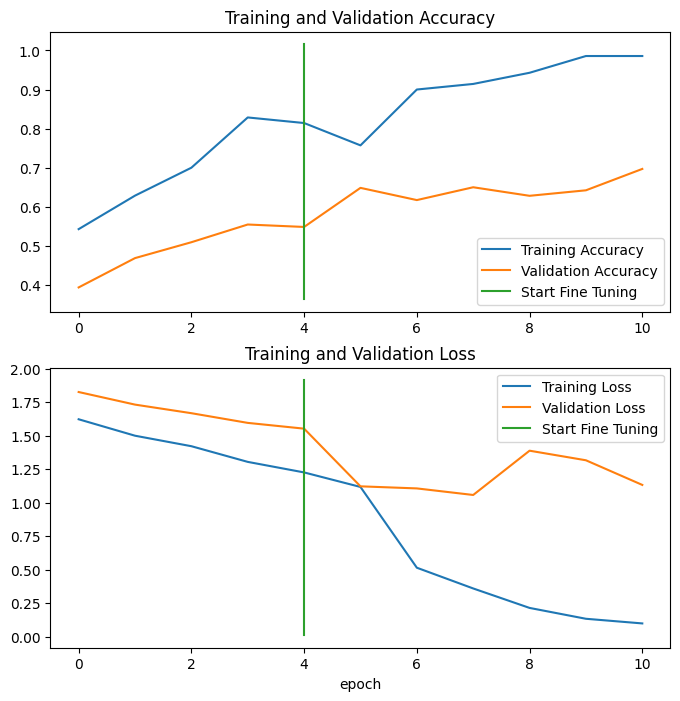

In [ ]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4 - Fine tuning on model with 100% data

In [ ]:
# Download and unzip 10 classes data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2024-06-03 12:58:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.207, 108.177.12.207, 108.177.11.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  23.7MB/s    in 8.9s    

2024-06-03 12:58:13 (55.6 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Set up training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.

In [ ]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode='categorical',
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments

In [ ]:
# Evaluate model 2
model_2.evaluate(test_data)

79/79 [==============================] - 7s 86ms/step - loss: 1.1578 - accuracy: 0.6916


[1.1578480005264282, 0.6916000247001648]

In [ ]:
results_fine_tune_10_percent

[1.1578477621078491, 0.6916000247001648]

To train a fine-tuning model (model_4), we need to revert model_2 back to its feature extraction weights.

In [ ]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10percent data model fine-tuned from.
model_2 = create_base_model(learning_rate=0.0001)

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
print(len(model_2.trainable_variables))

2


In [ ]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_4 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
model_2.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
fine_tune_epochs = initial_epoch + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                  experiment_name="full_10_classes_fine_tune")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune/20240603-131703
Epoch 5/10
24/24 [==============================] - 34s 1s/step - loss: 1.4936 - accuracy: 0.5707 - val_loss: 1.0815 - val_accuracy: 0.7188
Epoch 6/10
24/24 [==============================] - 21s 871ms/step - loss: 1.1288 - accuracy: 0.7107 - val_loss: 0.8467 - val_accuracy: 0.7796
Epoch 7/10
24/24 [==============================] - 19s 774ms/step - loss: 0.9692 - accuracy: 0.7427 - val_loss: 0.7205 - val_accuracy: 0.7977
Epoch 8/10
24/24 [==============================] - 21s 843ms/step - loss: 0.8238 - accuracy: 0.8013 - val_loss: 0.6659 - val_accuracy: 0.8059
Epoch 9/10
24/24 [==============================] - 21s 816ms/step - loss: 0.7504 - accuracy: 0.8040 - val_loss: 0.5967 - val_accuracy: 0.8372
Epoch 10/10
24/24 [==============================] - 26s 1s/step - loss: 0.7009 - accuracy: 0.8107 - val_loss: 0.5693 - val_accuracy: 0.8454


In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.5613 - accuracy: 0.8444


In [ ]:
results_fine_tune_full_data

[0.5612596273422241, 0.8443999886512756]

5
11
[0.5428571701049805, 0.6285714507102966, 0.699999988079071, 0.8285714387893677, 0.8142856955528259, 0.5706666707992554, 0.7106666564941406, 0.7426666617393494, 0.8013333082199097, 0.8040000200271606, 0.8106666803359985]


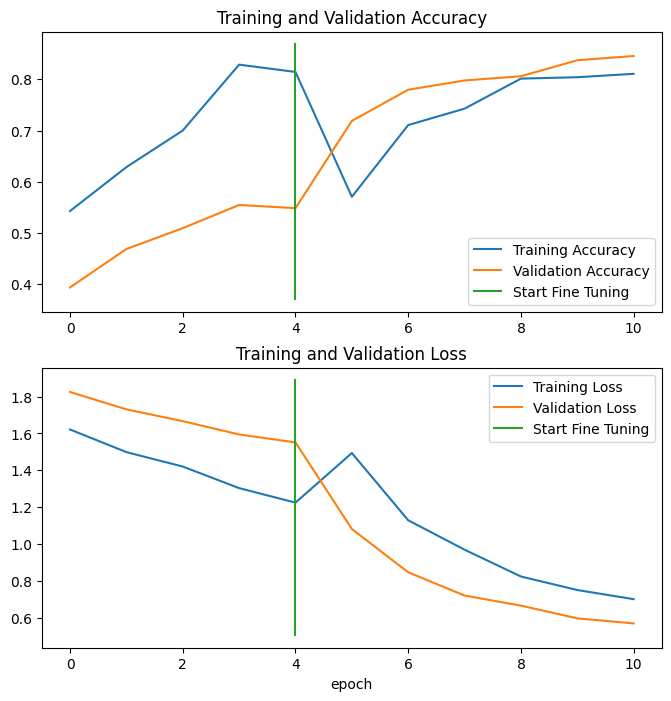

In [ ]:
compare_historys(history_10_percent_data_aug,
                history_fine_10_classes_full,
                initial_epochs=5)

## Viewing our model on TensorBoard

Anything you upload to TensorBoard.dev is going to be public.

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning/ \
 --name "Transfer Learning Experiments with 10 Food101 Classes" \
 --description "A series of different transfer learning experiments" \
 --one_shot # exits the uploader once its finished uploading

2024-06-03 13:28:04.986557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 13:28:04.986625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 13:28:04.991265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 13:28:06.505881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb